# Class Project (part A): 16/02/2021 <br>
---


Consider a cubic box of 18 angstrom. Generate 108 points random points inside the box such that that interparticle separation of any pair of points is not less than 3.4 A .  <br>
 You are generating a random initial configuration. 
 <br> xyz format.  <br>
 First line :- no.of atoms <br>
 Second line: any random comment <br>
 Next line onwards: C x y z  <br>
This is part of the project. <br>
Basically this is an ascii file. We should be able to visualize it with the help of VMD.

Write ur code in a modular fashion. <br>
1. Generate the coordinates
2. Calculate the potential energy of the configuration
3. Try to minimise the energy of the configuration. Go through **steepest descent algorithm** <br>
4. For diagonalization of the Hessian matrix, we can use pre-defined function

Part b of the project should be applying Monte-Carlo Method on this. 

## 1. Generate the coordinates and save in file

In [ ]:
from random import seed
from random import  random
import numpy as np

def isValid(arr,i,j,k,min,max):
    if (i>=min and i<=max and j>=min and j<=max and k>=min and k<=max):
        C = np.subtract(arr,np.array([i,j,k]))
        val = 0
        for i in range(len(C)):
            val = round(np.linalg.norm(C[i]),3)
            if (val < 3.4):
                return False
        return True
    else:
        return False

seed(1)
min = 0
max = 18
L = []
x = round(min + random()*(max - min),2)
y = round(min + random()*(max - min),2)
z = round(min + random()*(max - min),2)
L.append([x,y,z])
idx = 1
while (idx < 108):
    x = round(min + random()*(max - min),2)
    y = round(min + random()*(max - min),2)
    z = round(min + random()*(max - min),2)
    if (isValid(L,x,y,z,min,max)):
        L.append([x,y,z])
        idx += 1

In [ ]:
f = open("/content/drive/My Drive/Science-2/sample.xyz","w")
f.write("108\n")
f.write("# This is for showing the coordinates of the atoms \n")
c = 2
for i in range(len(L)):
    f.write("C "+str(L[i][0])+" "+str(L[i][1])+" "+str(L[i][2])+"\n")
    c += 1
f.close()

## 2. Calculate potential energy of configuration

In [ ]:
def calc_potential(A,B):
    A = np.array(A)
    B = np.array(B) 
    C = np.subtract(A,B)
    r = round(np.linalg.norm(C),1)
    val = 4*0.238*((3.4/r)**12-(3.4/r)**6)
    return val

def pot_arr(pos,l):
    U = [[0 for j in range(l)]for i in range(l)]
    E = 0
    for i in range(l):
        for j in range(i+1,l):
            U[i][j] = calc_potential(pos[i],pos[j])
            E += U[i][j]
    return U,round(E,5)
def dist_mat(pos,l):
    D = [[0 for j in range(108)]for i in range(108)]
    for i in range(108):
        for j in range(i+1,108):
            D[i][j] = round(np.linalg.norm(L[i]-L[j]),3)    

L = np.array(L)
P,energy = pot_arr(L,108)
D = dist_mat(L,108)
print('Total energy of configuration = ',energy,' kcal/mol')

Total energy of configuration =  -65.18293  kcal/mol


## 3. Minimize the potential energy of the system

In [ ]:
def calc_dist(a,b):                     # Dstance between two atoms
    c = np.subtract(a,b)
    r = round(np.linalg.norm(c),1)
    return r

def calc_pot_dev(A,B):                  # Derivative of potential energy between two atoms
    A = np.array(A)
    B = np.array(B) 
    C = np.subtract(A,B)
    r = round(np.linalg.norm(C),1)
    val_d = 4*0.238*(-((12*3.4**12)/(r**13)) + (6*3.4**6/(r**7)))       # Substituting into expression for derivative
    return val_d

def pot_dev_arr(pos,l):             # Computing derivative potential and updating current configuration
    dU = [[0 for j in range(l)]for i in range(l)]
    dE = 0
    pos_1 = [[0 for j in range(3)]for i in range(l)]
    for i in range(l):
        for j in range(i+1,l):
            c = 0
            dU[i][j] = calc_pot_dev(pos[i],pos[j])      # Matrix of gradients
            dE += dU[i][j]
            pos_1[i] = pos[i] - 0.1*dU[i][j]*np.ones(3)     # Selecting that configuration that minimises distance
            pos_1[j] = pos[j] + 0.1*dU[i][j]*np.ones(3)
            if (calc_dist(pos[i],pos[j]) < calc_dist(pos_1[i],pos_1[j])):
                pos_1[i] = pos[i] + 0.1*dU[i][j]*np.ones(3)
                pos_1[j] = pos[j] - 0.1*dU[i][j]*np.ones(3)
        
    new_E = pot_arr(pos_1,108)[1]
    print('Energy of resulting configuration = ',pot_arr(pos_1,108)[1])
    return dU,round(dE,5),new_E,pos_1

L1 = L.copy()       
energy = -65.18293              # From previous part
new_energy = -100                  # Dummy value
i = 1
dP = [[0 for j in range(108)]for i in range(108)]
while ((np.abs(energy - new_energy)>0.0005) and (energy > new_energy)):     # Steepest gradient algorithm implementing
    print('Iteration No.: ',i)

    if (i > 1):
        energy = new_energy
        dP = dP_1
    dP_1,d_energy,new_energy,L1 = pot_dev_arr(L1,108)
    
    print('Total energy derivative of configuration = ',d_energy)
    i += 1

Iteration No.:  1
Energy of resulting configuration =  -65.18855
Total energy derivative of configuration =  7.53541
Iteration No.:  2
Energy of resulting configuration =  -64.98585
Total energy derivative of configuration =  7.29571


Consider the potential energy value for iteration no. 1. <br>
The minimum potential energy of the system is: $-65.1885 kcal/mol$

## 4. Calculate Hessian matrix and get eigenvalues and eigenvectors and plot histogram of vibrational states

In [ ]:
from autograd import elementwise_grad as egrad
from autograd import jacobian
import autograd.numpy as np1

def pot_energy(p1,p2):
    return 4*0.238*((3.4/np1.linalg.norm(np1.subtract(p1,p2)))**12-(3.4/np1.linalg.norm(np1.subtract(p1,p2)))**6)

def Hessian(pos,l):
    pos = np1.array(pos)
    H = np1.zeros((3*l,3*l))
    H_f = jacobian(egrad(pot_energy))
    i,j = 0,3
    s,e = 0,0
    while (i < l):
        while (j < l):
            if (j != i+3):
                s = i//3
                e = j//3 - 1
                val = H_f(pos[s],pos[e])
                H[i][j],H[i][j+1],H[i][j+2] = val[0][0],val[0][1],val[0][2]
                H[i+1][j],H[i+1][j+1],H[i+1][j+2] = val[1][0],val[1][1],val[1][2]
                H[i+2][j],H[i+2][j+1],H[i+2][j+2] = val[2][0],val[2][1],val[2][2]
            j += 3
        j = 3
        i += 3
    return H

H = Hessian(L,108)

In [ ]:
w,v = np1.linalg.eig(H)

/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


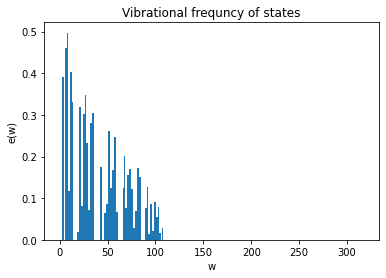

In [ ]:
freq = np1.sqrt(w)
l = len(freq)
freq = freq[:l-6]
plt.bar(list(range(318)),freq)
plt.xlabel('w')
plt.ylabel('e(w)')
plt.title('Vibrational frequncy of states')
plt.show()